In [1]:
"""from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate and download dataset
api = KaggleApi()
api.authenticate()
api.dataset_download_files('faviovaz/marketing-ab-testing', path='./data', unzip=True)"""

"from kaggle.api.kaggle_api_extended import KaggleApi\n\n# Authenticate and download dataset\napi = KaggleApi()\napi.authenticate()\napi.dataset_download_files('faviovaz/marketing-ab-testing', path='./data', unzip=True)"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("./data/marketing_AB.csv")

In [4]:
df

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


In [5]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

In [6]:
df["user id"].unique().shape[0] == df.shape[0]

True

We conclude the data has no repeated users so the user id columns is innecesary

In [7]:
df = df.drop( columns=["Unnamed: 0", "user id"] )

In [8]:
df.isna().any(axis=None)

np.False_

In [9]:
df["test group"].unique()

array(['ad', 'psa'], dtype=object)

In [10]:
df["most ads day"].unique()

array(['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday',
       'Thursday'], dtype=object)

Also we confirm that the data has no missing values for each event (user surveyed) and that each column has no unexpected values i.e. a third control group, a 8th day of the week.

In [11]:
df

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14
...,...,...,...,...,...
588096,ad,False,1,Tuesday,23
588097,ad,False,1,Tuesday,23
588098,ad,False,3,Tuesday,23
588099,ad,False,1,Tuesday,23


In [12]:
df.groupby("most ads day")["converted"].mean()

most ads day
Friday       0.022212
Monday       0.032812
Saturday     0.021051
Sunday       0.024476
Thursday     0.021571
Tuesday      0.029840
Wednesday    0.024942
Name: converted, dtype: float64

This tell us that there is more probability that a customer will convert if the day that sees most ads is Monday, and Tuesday. One possible reason is that at the beggining of the week the customers have more time to see the ads, I support this hypothesis because the days with fewers converts are all at the latter end of the week, (PEOPle generally spends less time on their phones, because of family, friends, etc...) So we could try to show more ads to our customers in monday and tuesday. I would like to prove it with a ML model.

In [13]:
contingency_table = pd.crosstab(df["test group"], df["converted"])
contingency_table

converted,False,True
test group,,
ad,550154,14423
psa,23104,420


I will perfom a z proportion one tail test to check if the ad campaign was succesful, my alpha is going to be of 5%

In [14]:
from scipy.stats import norm

n_ad = 550154+14423
p_ad = 14423/550154

n_psa = 23104+420
p_psa = 420/23104

d = p_ad - p_psa

p = (n_ad*p_ad + n_psa*p_psa)/(n_psa+n_ad)
pool_std = np.sqrt(p*(1-p)*(1/n_ad+1/n_psa))

observed_z_score = d/pool_std
critical_z_score = norm.ppf(0.95)

observed_z_score > critical_z_score

np.True_

So we conclude that the ad campaign was succesfull for an alpha of 5%!!!! congratulations to the marketing team, Now I'll proceed to check the p-value

In [15]:
p_value = 1 - norm.cdf(observed_z_score)
print("P-value:", p_value)

P-value: 1.4210854715202004e-14


Given that the p value is almost 0, we can conclude without a doubt the ad campaign was succesfull in improving the conversion rate, Now I would like explore more the data in order to find ways to improve the efficiency of the campaign and then I will train a ML model to target better our ads

In [16]:
day_to_int = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

group_to_int = {
    "psa": 0,
    "ad": 1
}

df["most ads day"] = df["most ads day"].map(day_to_int)
df["test group"] = df["test group"].map(group_to_int)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["test group", "converted"], axis=0).values
y = df["converted"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,    # Proportion of data for testing (e.g., 20%)
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the model (adjust hyperparameters as needed)
logreg = LogisticRegression(
    penalty='l2',        # Regularization type (L2 by default)
    solver='newton-cholesky',      # Algorithm for optimization (works for small datasets)
    max_iter=100000,       # Increase if model doesn't converge
    multi_class='ovr',
    class_weight="balanced"
)

# Fit the model to the training data
logreg.fit(X_train_scaled, y_train)

c:\Users\jdani\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=100000, multi_class='ovr',
                   solver='newton-cholesky')

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = logreg.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.86

Confusion Matrix:
[[99127 15646]
 [  844  2004]]

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.86      0.92    114773
        True       0.11      0.70      0.20      2848

    accuracy                           0.86    117621
   macro avg       0.55      0.78      0.56    117621
weighted avg       0.97      0.86      0.91    117621



AUC Score: 0.8592
Optimal threshold based on Youden's Index: 0.43


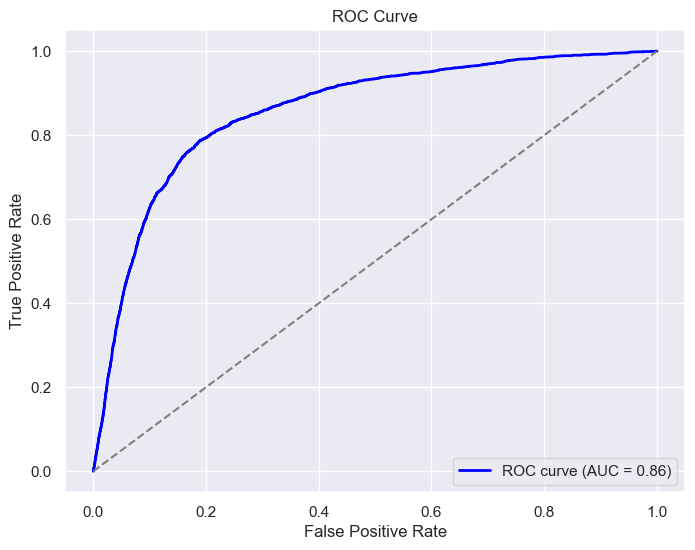

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

sns.set_theme()

# Predicted probabilities for the positive class
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

# Calculate Youden's Index (TPR - FPR)
youden_index = tpr - fpr

# Find the threshold that maximizes Youden's Index
optimal_threshold_index = youden_index.argmax()
optimal_threshold = thresholds[optimal_threshold_index]

print(f"Optimal threshold based on Youden's Index: {optimal_threshold:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The logistic model does a good job in predicting possible converts (we have ab AUC of 0.85 and the ROC curve is well above the diagonal line), but also because has a very low precision it also has a lot of false positives, but given that there is not much to lose targeting a unsuitable user, we could use this model as a first step. The next possible steps could be acquiring more data to have more features